In this tutorial we will see the explore the basic feature of **Elegy**. If you are a Keras user you should feel at home, are currently using Jax or Haiku things will appear much simpler. To get started you will first need to install the following dependencies:

In [ ]:
! pip install elegy dataget matplotlibpip install elegy dataget matplotlib

## Loading the Data
In this tutorial we will train a Neural Network on the MNIST dataset, for this we will first need download and load the data into memory. Here we will use `dataget` for simplicity but you can probably use you favorite datasets library.

In [4]:
import dataget

X_train, y_train, X_test, y_test = dataget.image.mnist(global_cache=True).get()

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

X_train: (60000, 28, 28) uint8
y_train: (60000,) uint8
X_test: (10000, 28, 28) uint8
y_test: (10000,) uint8


In this case `dataget` loads is the _official_ from Yann LeCun's website.

## Creating the Model
Now that we have the data we can define a model

In [2]:
import jax.numpy as jnp
import jax
import haiku as hk

def model_fn(image) -> jnp.ndarray:
    """Standard LeNet-300-100 MLP network."""
    image = image.astype(jnp.float32) / 255.0

    mlp = hk.Sequential(
        [
            hk.Flatten(),
            hk.Linear(300),
            jax.nn.relu,
            hk.Linear(100),
            jax.nn.relu,
            hk.Linear(10),
        ]
    )
    return mlp(image)

In [4]:
import elegy

model = elegy.Model(
    model_fn=model_fn,
    loss=lambda: elegy.losses.SparseCategoricalCrossentropy(from_logits=True),
    aux_losses=lambda: elegy.regularizers.GlobalL2Regularization(l=1e-4),
    metrics=lambda: elegy.metrics.SparseCategoricalAccuracy(),
)

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=64,
    steps_per_epoch=100,
    validation_data=(X_test, y_test),
    shuffle=True,
)

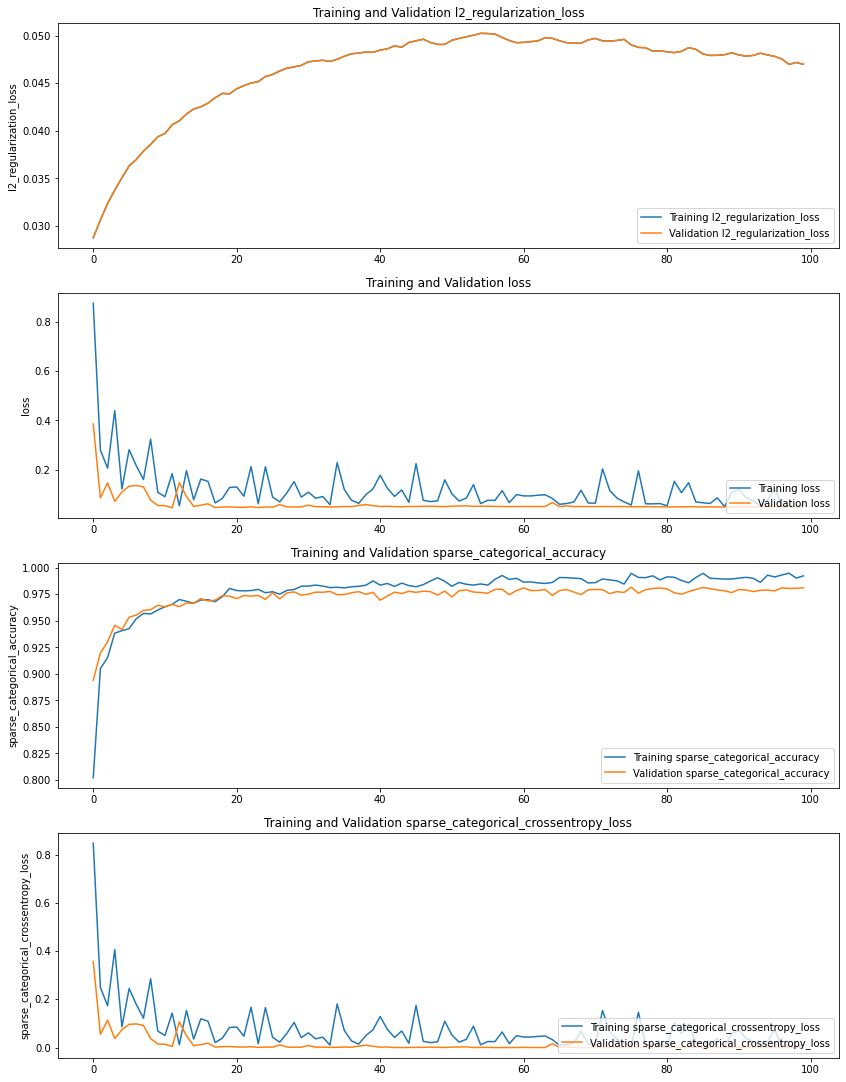

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):
    n_plots = len(history.history.keys()) // 2
    plt.figure(figsize=(14, 24))
    
    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        if key == "size":
            continue
        
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, label=f"Training {key}")
        plt.plot(val_metric, label=f"Validation {key}")
        plt.legend(loc="lower right")
        plt.ylabel(key)
#         plt.ylim([min(plt.ylim()), 1])
        plt.title(f"Training and Validation {key}")
    plt.show()
    
plot_history(history)

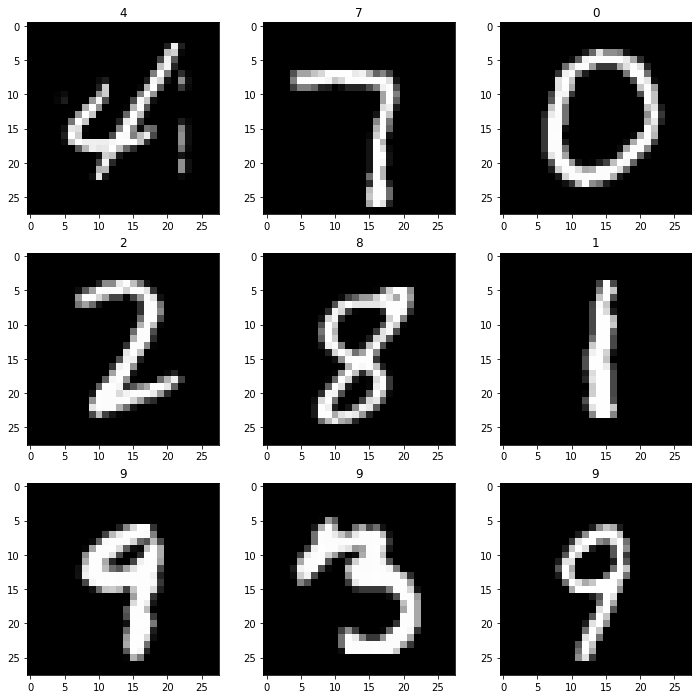

In [10]:
import numpy as np

# get random samples
idxs = np.random.randint(0, 10000, size=(9,))
x_sample = X_test[idxs]

# get predictions
y_pred = model.predict(x=x_sample)

# plot results
plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)
    
        plt.title(f"{np.argmax(y_pred[k])}")
        plt.imshow(x_sample[k], cmap="gray")